<a href="https://colab.research.google.com/github/robbalian/StravaTimes/blob/main/%5BPublic%5D_Strava_Segment_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Strava Segment Times over time
# I love strava, but they want to charge $7/month to see the list of my activity times on a given segment.
# That seems a bit extreme, so I built this tool so analyze particular segments and my rides over the years.

# Here's what you'll need to run this notebook
# 1/ Your strava bulk export or GPX files. The bulk export is easy and you can find it here: https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export#h_01GG58HC4F1BGQ9PQZZVANN6WF
# 2/ A segment to get your times on. You can grab the JSON for a segment by going to "https://www.strava.com/stream/segments/<segment_id>?streams%5B%5D=latlng" and saving as eg hawkhill.json, then uploading to Colab.
#    For Hawk Hill in Marin California, that URL is https://www.strava.com/stream/segments/229781?streams%5B%5D=latlng
#    That's it. Please use and help contribute if you're excited about this.

In [ ]:
# Upload your strava export .zip to Google Colab
!! mkdir strava_export
!! unzip export_XXXXXX.zip -d /content/strava_export

In [ ]:
!! pip install fit2gpx gpxpy

In [ ]:
from fit2gpx import StravaConverter

DIR_STRAVA = '/content/strava_export'

# Convert strava files to gpx. From the export they may be .fit or compressed files
# Note: This can take a while. It took 3 minutes for my 500 activities, but we only have to do it once

strava_conv = StravaConverter(
    dir_in=DIR_STRAVA
)

# Step 2: Unzip the zipped files
strava_conv.unzip_activities()

# Step 3: Add metadata to existing GPX files
strava_conv.add_metadata_to_gpx()

# Step 4: Convert FIT to GPX
strava_conv.strava_fit_to_gpx()

In [ ]:
files = [f for f in os.listdir('/content/activities_gpx') if f.endswith('.gpx')]
print(len(files))

591


In [ ]:
import gpxpy
import pandas as pd
import os
from tqdm import tqdm

# Now we load the GPX files to dataframe

def convert_gpx_to_dataframe(gpx_path):
  with open(gpx_path) as f:
    # if f is empty continue
    if f.read() == '':
      return None
    f.seek(0)
    gpx = gpxpy.parse(f)

  # Convert to a dataframe one point at a time.
  points = []
  for segment in gpx.tracks[0].segments:
      for p in segment.points:
          points.append({
              'time': p.time,
              'latitude': p.latitude,
              'longitude': p.longitude,
              'elevation': p.elevation,
          })
  df = pd.DataFrame.from_records(points)
  return df


def load_gpx_to_dataframes(gpx_folder):
    dfs = []
    # Get all .gpx files in the input directory
    gpx_files = [f for f in os.listdir(gpx_folder) if f.endswith('.gpx')]

    # Process each file
    for gpx_file in tqdm(gpx_files):
      # Create the full path to the input .gpx file
      dfs.append(convert_gpx_to_dataframe(os.path.join(gpx_folder, gpx_file)))

    return dfs

gpx_folder_path = '/content/activities_gpx'
dfs = load_gpx_to_dataframes(gpx_folder_path)

100%|██████████| 591/591 [02:42<00:00,  3.64it/s]


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np

def analyze_segment_in_ride(ride_data, segment_points, proximity_threshold=25, completion_percentage=75):
    # Convert ride data and segment points to GeoDataFrames
    ride_geometry = [Point(xy) for xy in zip(ride_data['longitude'], ride_data['latitude'])]
    segment_geometry = [Point(lon, lat) for lat, lon in segment_points]
    geo_df_ride = gpd.GeoDataFrame(ride_data, geometry=ride_geometry)
    geo_df_segment = gpd.GeoDataFrame(geometry=segment_geometry)

    threshold_degrees = proximity_threshold / 111320  # convert meters to degrees

    def is_within_threshold(point, line):
        return point.distance(line) < threshold_degrees

    # Create a LineString from the segment points
    segment_line = LineString(geo_df_segment.geometry)

    # Find all ride points close to the first and last segment point
    start_matches = [i for i, ride_point in enumerate(geo_df_ride.geometry) if ride_point.distance(geo_df_segment.geometry.iloc[0]) < threshold_degrees]
    end_matches = [i for i, ride_point in enumerate(geo_df_ride.geometry) if ride_point.distance(geo_df_segment.geometry.iloc[-1]) < threshold_degrees]
    #print(start_matches)
    #print(end_matches)

    if not start_matches or not end_matches:
        return {'rode_segment': False, 'percentage_close': 0}

    # Identify the range within the ride to check
    #latest_start = max(start_matches)
    for latest_start in start_matches:
      earliest_end = min(end_matches)

      if latest_start >= earliest_end:  # Segment points must be in the correct order
        continue

      # Check the intermediate ride points
      intermediate_ride_points = geo_df_ride.geometry[latest_start:earliest_end + 1]  # Include the "end" point
      close_points_count = sum(is_within_threshold(ride_point, segment_line) for ride_point in intermediate_ride_points)

      percentage_close = (close_points_count / len(intermediate_ride_points)) * 100

      if percentage_close >= completion_percentage:
          start_time = ride_data.iloc[latest_start]['time']
          end_time = ride_data.iloc[earliest_end]['time']
          duration = pd.to_datetime(end_time) - pd.to_datetime(start_time)
          return {
              'rode_segment': True,
              'percentage_close': percentage_close,
              'start_time': start_time,
              'end_time': end_time,
              'duration': duration
          }

      return {'rode_segment': False, 'percentage_close': percentage_close}

In [ ]:
import pandas as pd
import json

def load_ride_data(csv_file_path):
    """
    Load ride data from a CSV file into a pandas DataFrame.
    """
    ride_data = pd.read_csv(csv_file_path)
    #geometry_ride = [Point(xy) for xy in zip(ride_data['longitude'], ride_data['latitude'])]
    #geo_df_ride = gpd.GeoDataFrame(ride_data, geometry=geometry_ride)

    return ride_data

def load_segment_data(json_file_path):
    """
    Load segment data from a JSON file into a list of tuples.
    """
    with open(json_file_path, 'r') as file:
        segment_data = json.load(file)
        # Assuming the JSON structure is a dictionary with 'features' as a key
        # and coordinates are in a list as [longitude, latitude]
        segment_points = [(point[0], point[1]) for point in segment_data['latlng']]

    # Convert segment points to GeoDataFrame

    #geometry_segment = [Point(lon, lat) for lat, lon in segment_points]
    #geo_df_segment = gpd.GeoDataFrame(geometry=geometry_segment)
    return segment_points

def ride_data_to_geodataframe(ride_data):
    geometry_ride = [Point(xy) for xy in zip(ride_data['longitude'], ride_data['latitude'])]
    geo_df_ride = gpd.GeoDataFrame(ride_data, geometry=geometry_ride)
    return geo_df_ride

def segment_points_to_geodataframe(segment_points):
    geometry_segment = [Point(lon, lat) for lat, lon in segment_points]
    geo_df_segment = gpd.GeoDataFrame(geometry=geometry_segment)
    return geo_df_segment


# Here we're checking if the last activity went through the hawkhill segment
ride_data = dfs[-1]

segment_data_path = 'oldlahonda.json'

# You can grab the JSON for the ride by going to "https://www.strava.com/stream/segments/229781?streams%5B%5D=latlng" and saving as eg hawkhill.json, then uploading to Colab
segment_points = load_segment_data(segment_data_path)

analysis_results = analyze_segment_in_ride(ride_data, segment_points)

print(analysis_results)

{'rode_segment': False, 'percentage_close': 0}


In [ ]:
from shapely.geometry import box

def ride_intersects_segment(ride_data, segment_data):
    # Create a bounding box for the ride
    ride_bounds = ride_data.total_bounds  # returns (minx, miny, maxx, maxy)
    ride_bbox = box(*ride_bounds)

    # Create a bounding box for the segment
    segment_bounds = segment_data.total_bounds  # returns (minx, miny, maxx, maxy)
    segment_bbox = box(*segment_bounds)

    # Check for intersection between the ride and segment bounding boxes
    return ride_bbox.intersects(segment_bbox)


In [ ]:
# Here we're running a faster check to see if each ride was near hawk hill segment, and getting a shortlist of potential ride matches

hawk_potentials = []
segment_geo_df = segment_points_to_geodataframe(segment_points)  # your segment data as a GeoDataFrame
for df in tqdm(dfs):
  try:
    ride_geo_df = ride_data_to_geodataframe(df)  # your ride data as a GeoDataFrame
  except:
    print('failing, passing on')
    continue
  if ride_intersects_segment(ride_geo_df, segment_geo_df):
    hawk_potentials.append(ride_geo_df)
    print('true')

  8%|▊         | 48/591 [00:01<00:15, 35.40it/s]

true


  9%|▉         | 52/591 [00:01<00:17, 30.72it/s]

true


 13%|█▎        | 74/591 [00:02<00:29, 17.43it/s]

true


 14%|█▍        | 84/591 [00:03<00:27, 18.63it/s]

true


 17%|█▋        | 99/591 [00:04<00:20, 23.90it/s]

true


 18%|█▊        | 106/591 [00:04<00:19, 24.49it/s]

true


 24%|██▎       | 140/591 [00:06<00:15, 29.51it/s]

true
true
true


 31%|███▏      | 186/591 [00:07<00:13, 30.22it/s]

true
true


 36%|███▌      | 211/591 [00:08<00:10, 35.62it/s]

failing, passing on
true


 37%|███▋      | 219/591 [00:08<00:10, 34.33it/s]

true


 40%|███▉      | 235/591 [00:09<00:13, 26.70it/s]

true


 44%|████▎     | 258/591 [00:10<00:09, 33.39it/s]

true


 49%|████▊     | 288/591 [00:10<00:07, 40.21it/s]

true


 50%|█████     | 298/591 [00:11<00:11, 24.54it/s]

true


 52%|█████▏    | 310/591 [00:11<00:09, 28.18it/s]

true


 54%|█████▍    | 318/591 [00:12<00:09, 28.76it/s]

true


 64%|██████▍   | 379/591 [00:14<00:10, 20.39it/s]

true


 70%|██████▉   | 412/591 [00:16<00:09, 18.68it/s]

true


 72%|███████▏  | 424/591 [00:17<00:10, 15.98it/s]

true


 74%|███████▍  | 436/591 [00:17<00:07, 20.83it/s]

true


 76%|███████▌  | 449/591 [00:18<00:04, 32.07it/s]

true
true


 79%|███████▊  | 464/591 [00:18<00:05, 25.18it/s]

true


 81%|████████  | 480/591 [00:19<00:03, 32.30it/s]

true


 87%|████████▋ | 515/591 [00:20<00:01, 40.80it/s]

true
true


 90%|████████▉ | 531/591 [00:20<00:01, 40.54it/s]

true


 96%|█████████▌| 568/591 [00:22<00:00, 32.92it/s]

true


100%|██████████| 591/591 [00:22<00:00, 25.90it/s]


In [ ]:
# And finally, on the shortlist, getting the actual time and confirming whether or not the activity matched the segment

segment_points = load_segment_data(segment_data_path)[:-10] #chopping last 10 points off. Seems to include extra points
df = pd.DataFrame(columns=['duration','start_time'])
for ride_geo_df in hawk_potentials:
  analysis_results = analyze_segment_in_ride(ride_geo_df, segment_points)
  if analysis_results['rode_segment']:
    dfs_to_concat = [df, pd.DataFrame.from_dict(analysis_results, orient='index').T]
    df = pd.concat(dfs_to_concat, ignore_index=True)
  print(analysis_results)


{'rode_segment': False, 'percentage_close': 0}
{'rode_segment': True, 'percentage_close': 99.57081545064378, 'start_time': Timestamp('2013-07-31 01:25:53+0000', tz='SimpleTZ("Z")'), 'end_time': Timestamp('2013-07-31 01:46:52+0000', tz='SimpleTZ("Z")'), 'duration': Timedelta('0 days 00:20:59')}
{'rode_segment': True, 'percentage_close': 98.71685201026519, 'start_time': Timestamp('2013-03-27 00:53:04+0000', tz='SimpleTZ("Z")'), 'end_time': Timestamp('2013-03-27 01:13:53+0000', tz='SimpleTZ("Z")'), 'duration': Timedelta('0 days 00:20:49')}
{'rode_segment': True, 'percentage_close': 94.61883408071749, 'start_time': Timestamp('2012-03-23 23:21:19+0000', tz='SimpleTZ("Z")'), 'end_time': Timestamp('2012-03-23 23:43:37+0000', tz='SimpleTZ("Z")'), 'duration': Timedelta('0 days 00:22:18')}
{'rode_segment': True, 'percentage_close': 94.43099273607749, 'start_time': Timestamp('2012-04-17 23:36:50+0000', tz='SimpleTZ("Z")'), 'end_time': Timestamp('2012-04-17 23:57:27+0000', tz='SimpleTZ("Z")'), 'du

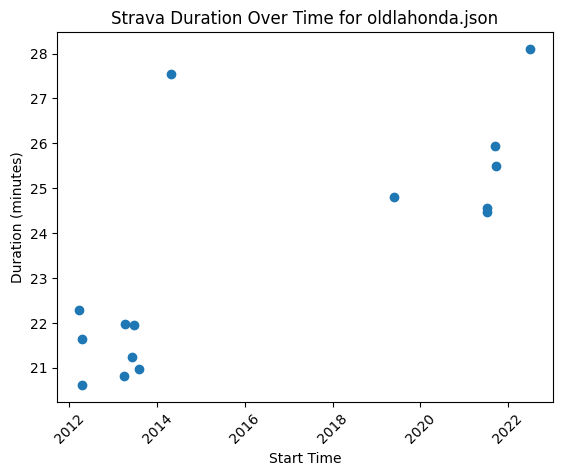

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Finally, let's plot the activities and their times

# Define the float_to_minutes_seconds function
def float_to_minutes_seconds(minutes_float):
    minutes = int(minutes_float)
    seconds = int((minutes_float - minutes) * 60)
    time_str = f"{minutes:02d}:{seconds:02d}"
    return time_str

# Create a new column 'duration_string' using apply


# Ensure that 'start_time' is in datetime format and 'duration_minutes' is a numerical value
df['start_time'] = df['start_time'].dt.tz_localize(None)
df['start_time'] = pd.to_datetime(df['start_time'])
df['duration_minutes'] = df['duration'].dt.total_seconds() / 60  # if 'duration_minutes' is not already calculated
df['duration_string'] = df['duration_minutes'].apply(float_to_minutes_seconds)

# Get the current date and calculate the date 6 months ago
current_date = pd.to_datetime('today')
six_months_ago = current_date - pd.DateOffset(months=2000)

# Filter the DataFrame to only include data from the last 6 months
recent_df = df[df['start_time'] >= six_months_ago]

# Create the plot with the filtered data
fig, ax = plt.subplots()
ax.scatter(recent_df['start_time'], recent_df['duration_minutes'])

# Making the x-axis labels more readable
#ax.xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # dates in 'YYYY-MM' format.
plt.xticks(rotation=45)  # rotate date labels for better fit

# Set labels and title
ax.set_xlabel('Start Time')
ax.set_ylabel('Duration (minutes)')
ax.set_title('Strava Duration Over Time for ' + segment_data_path)

plt.show()


In [ ]:
# And the list
print(df[['start_time','duration_string']].sort_values(by=['start_time']))

            start_time duration_string
2  2012-03-23 23:21:19           22:18
10 2012-04-14 22:49:37           21:38
3  2012-04-17 23:36:50           20:37
1  2013-03-27 00:53:04           20:48
12 2013-04-11 00:53:30           21:59
6  2013-06-07 01:16:34           21:15
14 2013-06-20 01:03:22           21:56
0  2013-07-31 01:25:53           20:59
8  2014-04-24 00:20:57           27:33
5  2019-06-01 00:34:34           24:48
9  2021-07-11 21:11:35           24:33
7  2021-07-11 21:12:01           24:27
13 2021-09-11 20:09:06           25:56
4  2021-09-26 21:36:14           25:30
11 2022-07-07 01:42:50           28:06
